In [218]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.datasets import load_wine
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score, silhouette_score, adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tqdm import trange

# GraphEncoder
From the paper: [Learning Deep Representations for Graph Clustering](https://cdn.aaai.org/ojs/8916/8916-13-12444-1-2-20201228.pdf)

## Loading the data
We use the wine dataset such as used in the paper.

In [219]:
dataset = load_wine()
X, Y = MinMaxScaler().fit_transform(dataset['data']), dataset['target']
X.shape, Y.shape

((178, 13), (178,))

## Preprocessing the data
The paper uses cosine similarity as the similarity measure between nodes. We will use the same.

In [220]:
S = cosine_similarity(X, X)
D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
X_train = torch.tensor(D @ S).float()
X_train[:5, :5]

tensor([[0.0813, 0.0791, 0.0781, 0.0785, 0.0763],
        [0.0805, 0.0827, 0.0776, 0.0793, 0.0748],
        [0.0772, 0.0754, 0.0803, 0.0771, 0.0768],
        [0.0794, 0.0788, 0.0789, 0.0822, 0.0751],
        [0.0743, 0.0716, 0.0757, 0.0723, 0.0791]])

## GraphEncoder Model
The model is a simple Autoencoder with three fully connected layers in the encoder and same in the decoder. 

In [221]:
class GraphEncoder(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int):
		super(GraphEncoder, self).__init__()
		self.encoder = nn.Sequential(
			nn.Linear(in_channels, 4 * latent_dim),
			nn.ReLU(),
			nn.Linear(4 * latent_dim, 2 * latent_dim),
			nn.ReLU(),
			nn.Linear(2 * latent_dim, latent_dim),
		)
		self.decoder = nn.Sequential(
			nn.Linear(latent_dim, 2 * latent_dim),
			nn.ReLU(),
			nn.Linear(2 * latent_dim, 4 * latent_dim),
			nn.ReLU(),
			nn.Linear(4 * latent_dim, in_channels),
		)
	
	def encode(self, x: torch.tensor) -> torch.tensor:
		return self.encoder(x)
	
	def decode(self, z: torch.tensor) -> torch.tensor:
		return self.decoder(z)
	
	def forward(self, x: torch.tensor) -> torch.tensor:
		z = self.encode(x)
		return self.decode(z), z
	
	def loss(self, x_hat: torch.tensor, x: torch.tensor) -> torch.tensor:
		return F.mse_loss(x_hat, x)

## Clustering utils
We use KMeans for clustering after the encoding and evaluate the clustering using the NMI, ARI, and Silouhette score.

In [222]:
def get_clusters(z: np.ndarray, n_clusters: int):
	kmeans = KMeans(n_clusters=n_clusters).fit(z)
	return kmeans.labels_

In [223]:
def evaluate_clustering(z: np.ndarray, true_labels: np.ndarray, cluster_labels: np.ndarray):
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    silouhette = silhouette_score(z, cluster_labels)
    return nmi, ari, silouhette

## Training the model
The model is trained to reconstruct the graph by minimizing the MSELoss between the original and reconstructed graph.

In [224]:
def train(model: nn.Module, optimizer: optim.Optimizer, x: torch.tensor) -> float:
	optimizer.zero_grad()
	x_hat, _ = model(x)
	loss = model.loss(x_hat, x)
	loss.backward()
	optimizer.step()
	return loss.item()

In [225]:
latent_dim, num_epochs, lr, n_clusters = 16, 100, .01, len(np.unique(Y))
model = GraphEncoder(len(X_train[0]), latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [226]:
losses, nmis = [], []
for epoch in (pbar := trange(num_epochs, desc="Epochs")):
	loss = train(model, optimizer, X_train)
	z = model.encode(X_train).detach().numpy()
	nmi, ari, silouhette = evaluate_clustering(z, Y, get_clusters(z, n_clusters))
	losses.append(loss), nmis.append(nmi)
	pbar.set_postfix({"Loss": loss, "NMI": nmi, "ARI": ari, "Silouhette": silouhette})

Epochs: 100%|██████████| 100/100 [00:03<00:00, 29.92it/s, Loss=4.91e-5, NMI=0.576, ARI=0.436, Silouhette=0.683] 


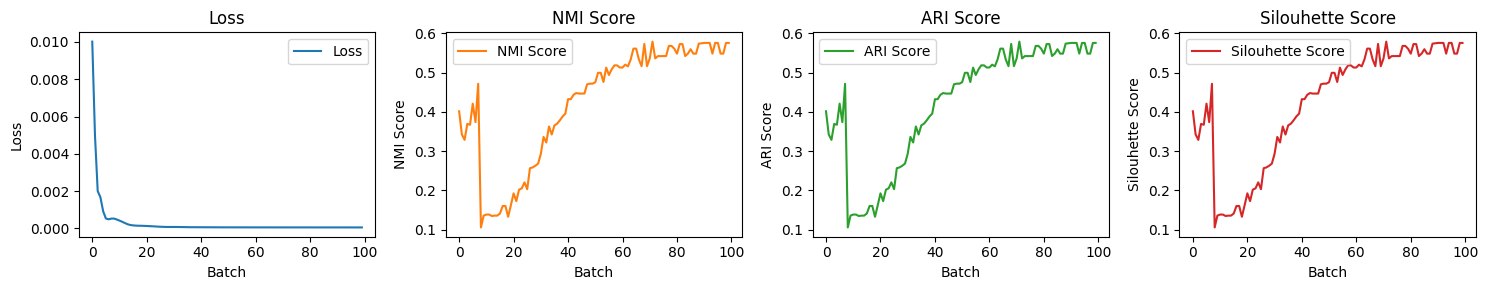

In [227]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
plt.title("Training loss and NMI evolution")
labels = ['Loss', 'NMI Score', 'ARI Score', 'Silouhette Score']
for i in range(4):
  ax = axs[i]
  ax.set_title(f'{labels[i]}')
  ax.set_xlabel('Batch')
  ax.set_ylabel(f'{labels[i]}')
  data = losses if i == 0 else nmis
  ax.plot(data, label=f'{labels[i]}', color=f'C{i}')
  ax.legend()

plt.tight_layout()
plt.show()

## Evaluating the model
We evaluate the model by clustering the latent space using KMeans and comparing the clustering with the true labels.

In [228]:
z = model.encode(X_train).detach().numpy()
cluster_labels = get_clusters(z, n_clusters)
true_labels = Y

nmi, ari, silouhette = evaluate_clustering(z, true_labels, cluster_labels)
print(f"NMI: {nmi}, ARI: {ari}, Silouhette score: {silouhette}")

NMI: 0.5757822290120982, ARI: 0.436075407120861, Silouhette score: 0.682693362236023


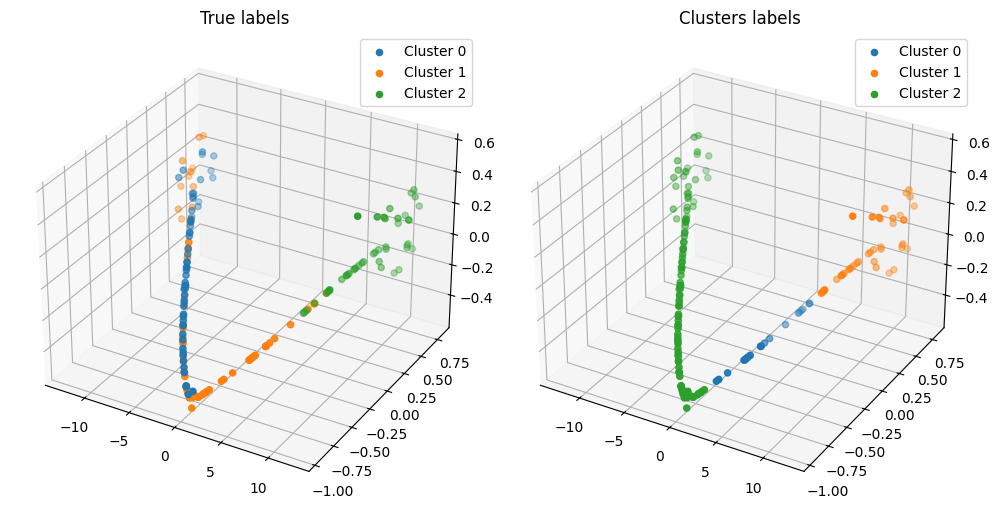

In [238]:
z_embedded = TSNE(n_components=3).fit_transform(z)

def plot_3d(z_embedded: np.ndarray, labels: np.ndarray, title: str, fig: plt.Figure, subplot_idx: int, subplots_nb: int) -> None:
	ax = fig.add_subplot(100 + 10 * subplots_nb + subplot_idx, projection='3d')
	ax.set_title(title)
	for i in range(n_clusters):
		ax.scatter(z_embedded[labels == i, 0], z_embedded[labels == i, 1], z_embedded[labels == i, 2], label=f"Cluster {i}")
	ax.legend()

fig = plt.figure(figsize=(15, 5))
plot_3d(z_embedded, true_labels, "True labels", fig, 1, 3)
plot_3d(z_embedded, cluster_labels, "Clusters labels", fig, 2, 3)

plt.tight_layout()
plt.show()